# Factor Research

$$
R_i - R_f = \alpha + \beta_{m, i} * (R_m - R_f) + \beta_{SMB, i} * f_{SMB} + \beta_{HML, i} * f_{HML} + \beta_{Momentum, i} * f_{Momentum} + \varepsilon
$$

- FF3~5 팩터 데이터와 grouping 데이터 (DAUM sectors, corr clustering)
- 팩터 선형 회귀를 이용한 return decomposition
- grouping data로 group neutralization을 한 다음 각 팩터의 demeaned-beta distribution을 확인

## 0. Import libraries & Data

- KRX 데이터를 바탕으로 생존 편향을 없앤 자체 데이터셋 라이브러리 `korquanttools`를 통해 데이터 생성
- 그 외 데이터는 NAVER/DAUM finance 데이터, 한국은행 데이터 등을 활용

In [149]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd
import numpy as np

import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

import pickle

In [150]:
import FinanceDataReader as fdr
import quantstats as qs

In [151]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

Data 기간은 아래와 같이 설정

- 추후 beta 계산을 위한 moving window도 설정함

In [152]:
# Global parameters

START = 20140101
END = 20221202

WINDOW = 252 # trading day 기준
# WINDOW = 60 # trading day 기준
# WINDOW = 20 # trading day 기준

In [153]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


### Factor data

#### 팩터 데이터 1: Market Excess Return

사용 데이터:
- 주가 수익률
    - 시가총액 가중을 위해 시가총액 데이터도 필요
- 무위험 수익률

** trading day 기준으로 되어있음

주가 수익률

In [154]:
## stock return
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [155]:
holidays = return_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='trdDd', length=2190, freq=None)

In [156]:
return_df = return_df.loc[tradingdays, :].copy()

In [157]:
return_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.011390,0.000000,0.022936,0.023102,-0.014745,-0.041176,-0.013605,0.015060,-0.024029,0.011839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.022523,0.004484,0.022422,-0.006452,-0.023129,0.024540,-0.013793,0.000000,-0.010994,-0.003158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.003304,0.000000,0.021930,-0.003247,0.012535,0.000000,0.011655,-0.026706,0.041587,0.002160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.005488,-0.002232,0.000000,0.003257,0.016506,-0.004491,0.000000,0.009146,0.047871,0.016095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.032751,0.011186,-0.021459,0.000000,-0.004060,-0.022556,-0.006912,-0.009063,0.015195,-0.002121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,-0.023385,-0.027119,-0.018018,-0.021396,-0.012214,-0.008850,-0.011538,0.000000,-0.013865,-0.005291,...,-0.028302,-0.032258,-0.042697,NaN,0.000000,0.002532,-0.002500,NaN,NaN,NaN
2022-11-29,0.007982,0.034843,0.000000,0.005754,0.013910,0.000000,0.017510,0.000000,0.008787,0.005319,...,-0.019417,-0.066667,-0.022300,0.000000,-0.011601,-0.002525,-0.002506,-0.070081,NaN,NaN
2022-11-30,0.020362,-0.003367,0.013761,0.052632,0.015244,0.014286,0.000000,0.000000,0.017422,0.007055,...,0.014851,0.000000,0.020408,0.000000,0.009390,0.000000,-0.002513,-0.078261,NaN,NaN


무위험 수익률

In [158]:
## risk free rate
## https://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=1073

rf_df = pd.read_excel('bok_risk_free_rate.xls', skiprows=2, nrows=7)

In [159]:
rf_df.set_index(keys=rf_df.columns[0], inplace=True)
rf_df.rename_axis(index=None, inplace=True)
rf_df = rf_df.T
rf_df.index = pd.to_datetime(rf_df.index, format='%Y%m월')


In [160]:
rf_df.columns

Index(['국고채 3년(평균)', '국고채 5년(평균)', '국고채 10년(평균)', '회사채 3년(평균)', 'CD 91물(평균)',
       '콜금리(1일물,평균)', '기준금리'],
      dtype='object')

risk-free rate는 한국은행 10년물 연이율을 일별로 환산하여 사용

In [161]:
rf_df = pd.DataFrame(rf_df[rf_df.columns[2]])
rf_df = rf_df.rename(columns={rf_df.columns[0]: 'bok_10y'})

In [162]:
rf_df

,bok_10y
2014-01-01,3.65
2014-02-01,3.52
2014-03-01,3.54
2014-04-01,3.54
2014-05-01,3.40
...,...
2022-06-01,3.64
2022-07-01,3.30
2022-08-01,3.32
2022-09-01,3.90


#### 팩터 데이터 2: SMB (Small Minus Big)

사용 데이터:
- 시가총액 데이터

In [163]:
# Data for 2nd Factor: SMB (Small Minus Big)

marcap_df = pricevolume.get_data("marketcap")

In [164]:
marcap_df = marcap_df.astype(float) # object로 되어있었음

In [165]:
marcap_df = marcap_df.loc[tradingdays, :].copy()
marcap_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,1.240157e+11,5.227152e+10,2.778912e+11,1.570596e+12,6.005292e+11,9.912291e+09,1.525406e+12,1.904283e+10,2.035340e+12,2.203634e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.268089e+11,5.251021e+10,2.841220e+11,1.560464e+12,5.866394e+11,1.015554e+10,1.504366e+12,1.904283e+10,2.013035e+12,2.196548e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,1.272278e+11,5.251021e+10,2.903527e+11,1.555397e+12,5.939928e+11,1.015554e+10,1.521899e+12,1.853426e+10,2.096679e+12,2.201272e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,1.279261e+11,5.239087e+10,2.903527e+11,1.560464e+12,6.037974e+11,1.010993e+10,1.521899e+12,1.870378e+10,2.197052e+12,2.236700e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,1.321159e+11,5.298757e+10,2.841220e+11,1.560464e+12,6.013462e+11,9.881885e+09,1.511379e+12,1.853426e+10,2.230509e+12,2.231977e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,2.449590e+11,5.518348e+10,2.988264e+11,4.943871e+12,5.541083e+11,1.702725e+10,1.802434e+12,1.830824e+10,4.166871e+12,6.660502e+10,...,8.442072e+10,1.419905e+11,9.696612e+10,1.128000e+10,6.508100e+09,1.212750e+10,8.079750e+09,7.873522e+10,NaN,NaN
2022-11-29,2.469142e+11,5.710625e+10,2.988264e+11,4.972317e+12,5.618162e+11,1.702725e+10,1.833994e+12,1.830824e+10,4.203487e+12,6.695930e+10,...,8.278148e+10,1.325245e+11,9.480373e+10,1.128000e+10,6.432600e+09,1.209688e+10,8.059500e+09,7.321738e+10,NaN,NaN
2022-11-30,2.519419e+11,5.691397e+10,3.029387e+11,5.234018e+12,5.703804e+11,1.727049e+10,1.833994e+12,1.830824e+10,4.276718e+12,6.743167e+10,...,8.401091e+10,1.325245e+11,9.673850e+10,1.128000e+10,6.493000e+09,1.209688e+10,8.039250e+09,6.748733e+10,NaN,NaN


#### 팩터 데이터 3: HML (High Minus Low)

사용 데이터:
- KRX Funda 데이터 (그 중 PBR)

In [166]:
# Data for 3rd Factor: HML (High Minus Low)

pbr_df = pd.read_pickle('temp_KRX_PBR_20140101_20221202.pkl')
pbr_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.55,0.82,0.41,1.38,0.48,NaN,1.09,NaN,1.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.56,0.83,0.42,1.37,0.47,NaN,1.08,NaN,1.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.56,0.83,0.43,1.37,0.47,NaN,1.09,NaN,1.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.56,0.82,0.43,1.37,0.48,NaN,1.09,NaN,1.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.58,0.83,0.42,1.37,0.48,NaN,1.08,NaN,1.92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,0.70,1.49,0.36,1.97,0.29,NaN,1.64,NaN,2.01,NaN,...,2.78,5.34,2.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-29,0.71,1.54,0.36,1.98,0.29,NaN,1.67,NaN,2.03,NaN,...,2.73,4.99,2.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,0.72,1.54,0.37,2.08,0.29,NaN,1.67,NaN,2.06,NaN,...,2.77,4.99,2.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 팩터 데이터 4: Momentum

사용 데이터:
- 주가 수익률

In [167]:
return_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.011390,0.000000,0.022936,0.023102,-0.014745,-0.041176,-0.013605,0.015060,-0.024029,0.011839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.022523,0.004484,0.022422,-0.006452,-0.023129,0.024540,-0.013793,0.000000,-0.010994,-0.003158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.003304,0.000000,0.021930,-0.003247,0.012535,0.000000,0.011655,-0.026706,0.041587,0.002160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.005488,-0.002232,0.000000,0.003257,0.016506,-0.004491,0.000000,0.009146,0.047871,0.016095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.032751,0.011186,-0.021459,0.000000,-0.004060,-0.022556,-0.006912,-0.009063,0.015195,-0.002121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,-0.023385,-0.027119,-0.018018,-0.021396,-0.012214,-0.008850,-0.011538,0.000000,-0.013865,-0.005291,...,-0.028302,-0.032258,-0.042697,NaN,0.000000,0.002532,-0.002500,NaN,NaN,NaN
2022-11-29,0.007982,0.034843,0.000000,0.005754,0.013910,0.000000,0.017510,0.000000,0.008787,0.005319,...,-0.019417,-0.066667,-0.022300,0.000000,-0.011601,-0.002525,-0.002506,-0.070081,NaN,NaN
2022-11-30,0.020362,-0.003367,0.013761,0.052632,0.015244,0.014286,0.000000,0.000000,0.017422,0.007055,...,0.014851,0.000000,0.020408,0.000000,0.009390,0.000000,-0.002513,-0.078261,NaN,NaN


## 1. Make Factor data

준비된 데이터들을 재료로 factor data를 만든다. 

모든 factor는 time series window를 따로 사용하지 않고 횡단면(cross-sectional) 으로 계산하여 구함. 

----

팩터 값을 구하기 위해 팩터 포트폴리오의 수익률을 구하게 되느데

이 때 나는 이전엔 일반적인 포트폴리오 수익률처럼 cap weighted를 해봤었다. 

하지만 그 결과 각 팩터는 market cap에 모두 노출이 되는 결과를 낳았기 때문에 Kenneth R. French 교수의 factor construction을 다시 살펴보니 다음과 같이 equal weighted를 하였고, 이에 맞게 factor portfolio 산식을 수정하였다. 

참고: 

```
SMB is the equal-weight average of the returns on the three small stock portfolios for the region minus the average of the returns on the three big stock portfolios,

SMB = 1/3 (Small Value + Small Neutral + Small Growth)
– 1/3 (Big Value + Big Neutral + Big Growth).

HML is the equal-weight average of the returns for the two high B/M portfolios for a region minus the average of the returns for the two low B/M portfolios,

HML = 1/2 (Small Value + Big Value)
– 1/2 (Small Growth + Big Growth).
```

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_developed.html

### Factor 1: Market Excess Return

$$
... + \beta_{m, i} * (R_m - R_f) + ...
$$

In [168]:
# 시가총액 가중 market return 
marcap_weights = marcap_df.divide(marcap_df.sum(axis=1), axis=0)
Rm = (return_df * marcap_weights).sum(axis=1)

In [169]:
# 한국은행 국채 10년물 금리를 daily interest rate으로 환산 (compound rate)
Rf = rf_df.reindex(Rm.index, method='ffill').squeeze()
Rf = (1 + Rf * 0.01) ** (1/252) - 1

In [170]:
mkt_excess_R = Rm - Rf
mkt_excess_R

trdDd
2014-01-02   -0.020248
2014-01-03   -0.009241
2014-01-06    0.004118
2014-01-07    0.003524
2014-01-08    0.001258
                ...   
2022-11-28   -0.013256
2022-11-29    0.010726
2022-11-30    0.014261
2022-12-01    0.004928
2022-12-02   -0.016618
Length: 2190, dtype: float64

### Factor 2: SMB

$$
... + \beta_{SMB, i} * f_{SMB} + ...
$$

> SMB(Small minus Big): 
>
> the average return on the three small portfolios minus is the average return on the big portfolios

$$
SMB = \dfrac{(Small Value + Small Neutral + Small Growth)}{3} – \dfrac{(Big Value +
Big Neutral + Big Growth)}{3}
$$

포트폴리오이기 때문에, 마찬가지로 시가총액 가중을 해야한다.

이 때, market 시가총액 weight를 재활용하지 않고, small/big 으로 만들어진 포트폴리오에서 따로 시가총액 weight를 구한다. 

In [171]:
def is_small_size(marcap_row: pd.Series):
    rank_threshold = len(marcap_row[~marcap_row.isna()]) * 1/3
    value_threshold = marcap_row.nsmallest(int(rank_threshold))
    selections = value_threshold.index

    return selections # 오직 small 에 해당하는 종목들의 index만 줌. 
    

In [172]:
def is_big_size(marcap_row: pd.Series):
    rank_threshold = len(marcap_row[~marcap_row.isna()]) * 1/3
    value_threshold = marcap_row.nlargest(int(rank_threshold))
    selections = value_threshold.index

    return selections
    

In [185]:
# index를 각 row에 넣어야 안해당 하는 것은 Nan으로 표시된 채로 DataFrame이 완성됨.
small_size_marcap_df = marcap_df.apply((lambda row: row[is_small_size(row)]), axis=1) 

# small 에 해당하는 marcap만 모아 이 포트폴리오에 맞는 weight를 계산

# cap weighted 가 아닌 equal weighted를 사용해줘야 한다. 
# small_size_marcap_weights = small_size_marcap_df.divide(small_size_marcap_df.sum(axis=1), axis=0)


# 이미 구해놓은 mask를 통해 쉽게 return을 구함. 
small_size_returns = return_df[~small_size_marcap_df.isnull()]

In [186]:
small_size_portfolio_returns = small_size_returns.mean(axis=1)
small_size_portfolio_returns

trdDd
2014-01-02   -0.000935
2014-01-03   -0.001023
2014-01-06    0.004830
2014-01-07    0.006823
2014-01-08    0.010366
                ...   
2022-11-28   -0.013347
2022-11-29    0.006729
2022-11-30    0.006010
2022-12-01    0.015033
2022-12-02   -0.000141
Length: 2190, dtype: float64

<AxesSubplot: >

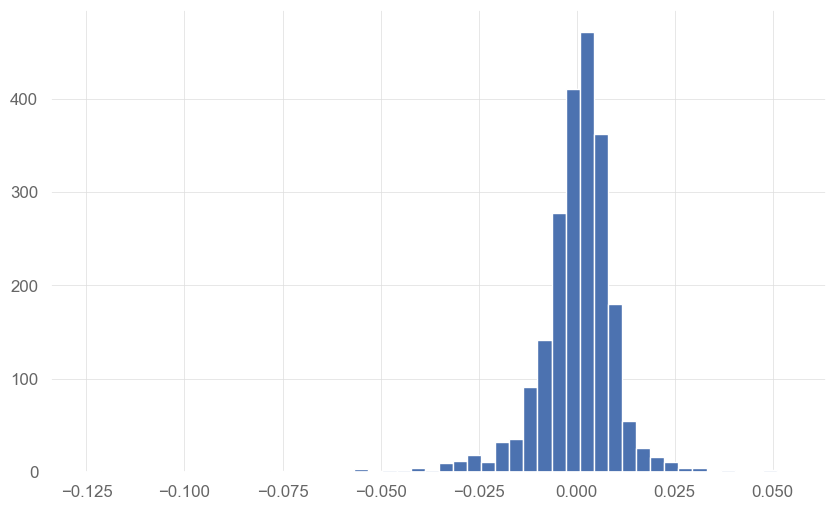

In [188]:
small_size_portfolio_returns.hist(bins=50)

In [189]:
scipy.stats.describe(small_size_portfolio_returns)

DescribeResult(nobs=2190, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

small cap일수록 negatively skewed 된 모습을 보여, abnormal return을 보여준다. 

In [190]:
small_size_portfolio_returns.describe()

count    2189.000000
mean        0.000098
std         0.010060
min        -0.124970
25%        -0.003783
50%         0.001042
75%         0.005481
max         0.054694
dtype: float64

In [191]:
big_size_marcap_df = marcap_df.apply((lambda row: row[is_big_size(row)]), axis=1)
# big_size_marcap_weights = big_size_marcap_df.divide(big_size_marcap_df.sum(axis=1), axis=0)
big_size_returns = return_df[~big_size_marcap_df.isnull()]

In [192]:
big_size_portfolio_returns = big_size_returns.mean(axis=1)
big_size_portfolio_returns

trdDd
2014-01-02   -0.010651
2014-01-03   -0.000790
2014-01-06    0.003625
2014-01-07    0.007734
2014-01-08    0.004623
                ...   
2022-11-28   -0.015265
2022-11-29    0.013410
2022-11-30    0.004717
2022-12-01    0.011858
2022-12-02   -0.008992
Length: 2190, dtype: float64

<AxesSubplot: >

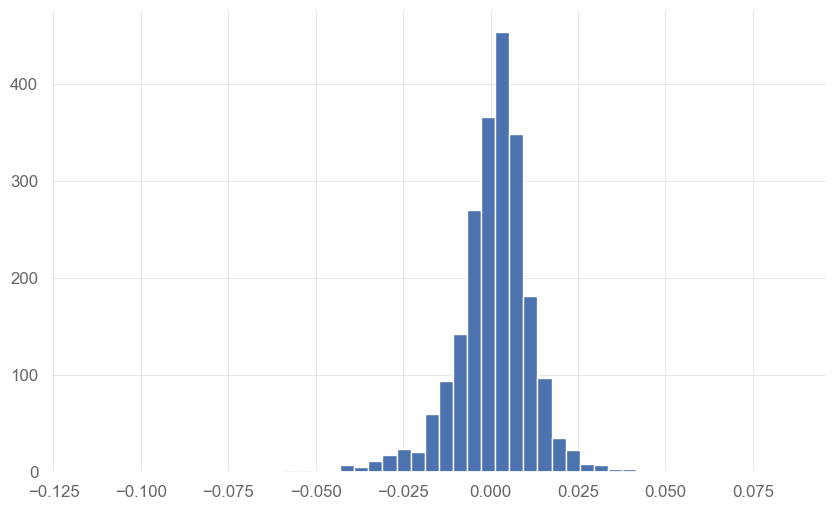

In [193]:
big_size_portfolio_returns.hist(bins=50)

In [194]:
scipy.stats.describe(big_size_portfolio_returns)

DescribeResult(nobs=2190, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

In [195]:
big_size_portfolio_returns.describe()

count    2189.000000
mean        0.000878
std         0.011548
min        -0.115540
25%        -0.004232
50%         0.001974
75%         0.006949
max         0.085936
dtype: float64

In [196]:
SMB = small_size_portfolio_returns - big_size_portfolio_returns
SMB

trdDd
2014-01-02    0.009716
2014-01-03   -0.000233
2014-01-06    0.001205
2014-01-07   -0.000911
2014-01-08    0.005743
                ...   
2022-11-28    0.001918
2022-11-29   -0.006681
2022-11-30    0.001293
2022-12-01    0.003175
2022-12-02    0.008851
Length: 2190, dtype: float64

### Factor 3: HML

$$
... + \beta_{HML, i} * f_{HML} + ...
$$

> HML(High minus Low): 
> 
> the average return on the two value portfolios minus is the average return on the two growth portfolios

$$
SMB = \dfrac{(Small Value + Big Value)}{2} – \dfrac{(Small Growth + Big Growth)}{2}
$$

$Book\text{-}to\text{-}Market \ ratio = \dfrac{장부가}{시가}$

$PBR(Price\text{-}to\text{-}Book \ ratio) = \dfrac{주가}{1 \ 주당 \ 장부가} = \dfrac{시가}{장부가}$

위의 공식에 따라 growth stock 일수록 PBR이 높고, value stock 일수록 PBR이 낮다. 

원래는 Book-to-Market ratio에 기초하기 때문에 High는 value, Low는 growth를 나타낸다는 점을 참고

In [197]:
def is_value(pbr_row: pd.Series): # = High = low PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nsmallest(int(rank_threshold))
    selections = value_threshold.index

    return selections # 오직 high 에 해당하는 종목들의 index만 줌. 
    

In [198]:
def is_growth(pbr_row: pd.Series): # = Low = high PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nlargest(int(rank_threshold))
    selections = value_threshold.index

    return selections
    

In [199]:
value_df = pbr_df.apply((lambda row: row[is_value(row)]), axis=1) 
value_marcap_df = marcap_df[~value_df.isnull()]
# value_marcap_weights = value_marcap_df.divide(value_marcap_df.sum(axis=1), axis=0)
value_returns = return_df[~value_df.isnull()]

In [200]:
value_portfolio_returns = value_returns.mean(axis=1)
value_portfolio_returns


trdDd
2014-01-02   -0.005477
2014-01-03   -0.000931
2014-01-06    0.003096
2014-01-07    0.005961
2014-01-08    0.002817
                ...   
2022-11-28   -0.014762
2022-11-29    0.010413
2022-11-30    0.009278
2022-12-01    0.011842
2022-12-02   -0.003537
Length: 2190, dtype: float64

<AxesSubplot: >

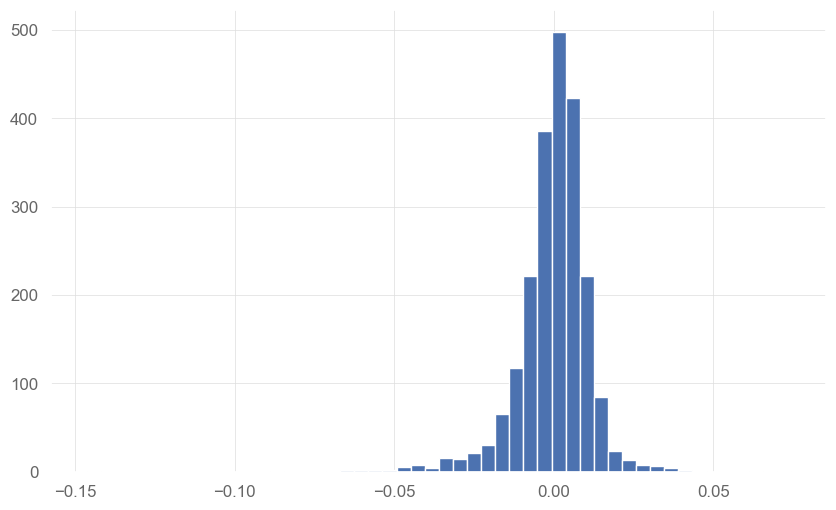

In [202]:
value_portfolio_returns.hist(bins=50)

In [203]:
scipy.stats.describe(value_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.14639439240956226, 0.0743932503189728), mean=-9.513776255573101e-05, variance=0.0001390224974082718, skewness=-1.7334309625458175, kurtosis=16.880286640935523)

In [204]:
value_portfolio_returns.describe()

count    2190.000000
mean       -0.000095
std         0.011791
min        -0.146394
25%        -0.004476
50%         0.001147
75%         0.005932
max         0.074393
dtype: float64

In [205]:
growth_df = pbr_df.apply((lambda row: row[is_growth(row)]), axis=1) 
growth_marcap_df = marcap_df[~growth_df.isnull()]
# growth_marcap_weights = growth_marcap_df.divide(growth_marcap_df.sum(axis=1), axis=0)
growth_returns = return_df[~growth_df.isnull()]

In [206]:
growth_portfolio_returns = growth_returns.mean(axis=1)
growth_portfolio_returns


trdDd
2014-01-02   -0.008769
2014-01-03    0.003010
2014-01-06    0.007093
2014-01-07    0.008419
2014-01-08    0.005433
                ...   
2022-11-28   -0.017890
2022-11-29    0.011232
2022-11-30    0.002582
2022-12-01    0.013069
2022-12-02   -0.002787
Length: 2190, dtype: float64

<AxesSubplot: >

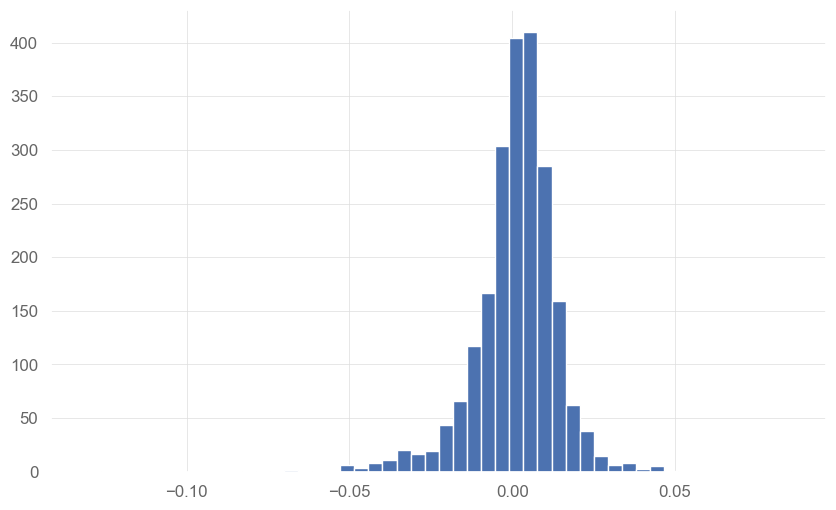

In [207]:
growth_portfolio_returns.hist(bins=50)

In [208]:
scipy.stats.describe(growth_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.13076831680803228, 0.08570719427242127), mean=0.0011946219136384252, variance=0.0001753282341277072, skewness=-1.0448863698177904, kurtosis=9.125200387517346)

In [209]:
growth_portfolio_returns.describe()

count    2190.000000
mean        0.001195
std         0.013241
min        -0.130768
25%        -0.004360
50%         0.002421
75%         0.008333
max         0.085707
dtype: float64

In [210]:
HML = value_portfolio_returns - growth_portfolio_returns
HML

trdDd
2014-01-02    0.003292
2014-01-03   -0.003941
2014-01-06   -0.003997
2014-01-07   -0.002458
2014-01-08   -0.002615
                ...   
2022-11-28    0.003128
2022-11-29   -0.000819
2022-11-30    0.006696
2022-12-01   -0.001228
2022-12-02   -0.000750
Length: 2190, dtype: float64

### Factor 4: Momentum

$$
... + \beta_{Momentum, i} * f_{Momentum} + ...
$$


** return decomposition 및 factor dashboard 완성하고 추가할 예정 **

## 2. Factor Portfolio 의 PnL 

In [211]:
mkt_factor_portfolio_PnL = (mkt_excess_R + 1).cumprod() - 1
SMB_factor_portfolio_PnL = (SMB + 1).cumprod() - 1
HML_factor_portfolio_PnL = (HML + 1).cumprod() - 1

<AxesSubplot: xlabel='trdDd'>

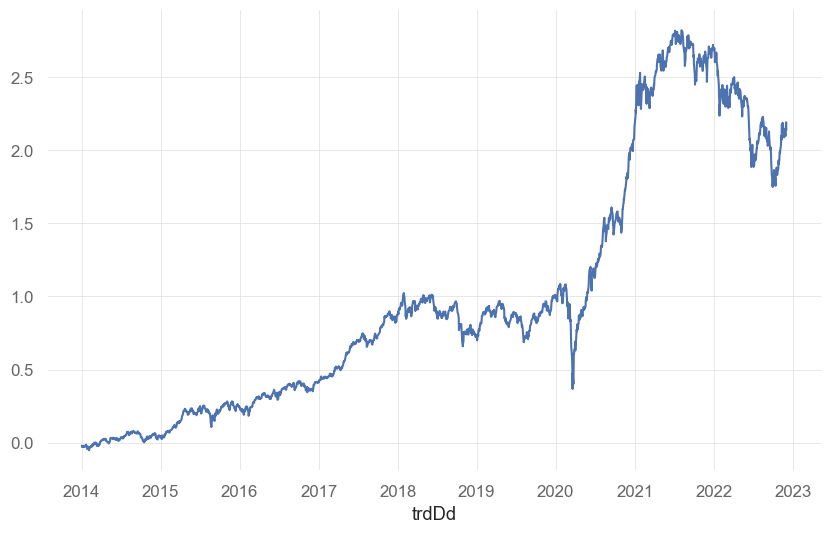

In [212]:
sns.lineplot(data=mkt_factor_portfolio_PnL)

market PnL은 대체로 내가 알고있는 상식대로 잘 나온다. covid 때 팍 찍었다가 바로 반등하는 모습 보여준다. 

하지만 SMB와 HML PnL은 두 팩터가 초과수익을 낸다는 말과는 달리 PnL이 심각하게 꼴아박는다. 

뭔가 factor 만들 때 계산이 잘못되었음을 암시하는 것인가?

<AxesSubplot: xlabel='trdDd'>

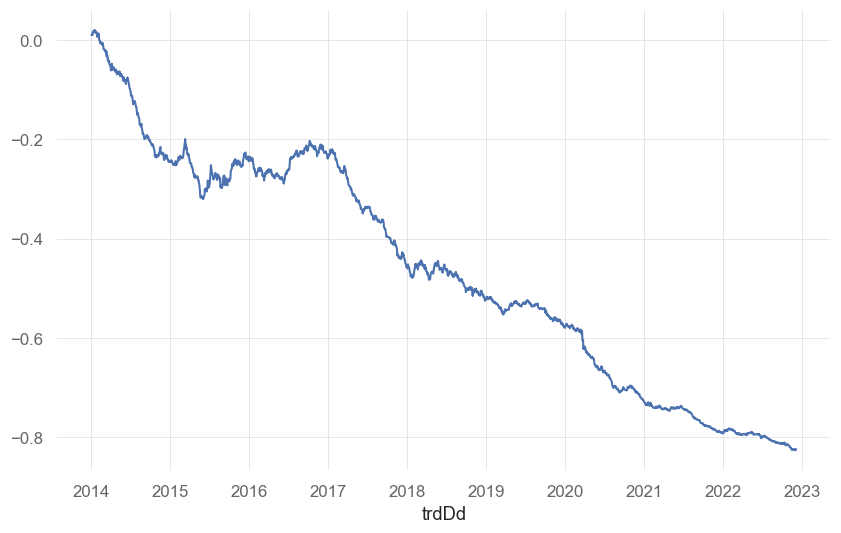

In [213]:
sns.lineplot(data=SMB_factor_portfolio_PnL)

<AxesSubplot: xlabel='trdDd'>

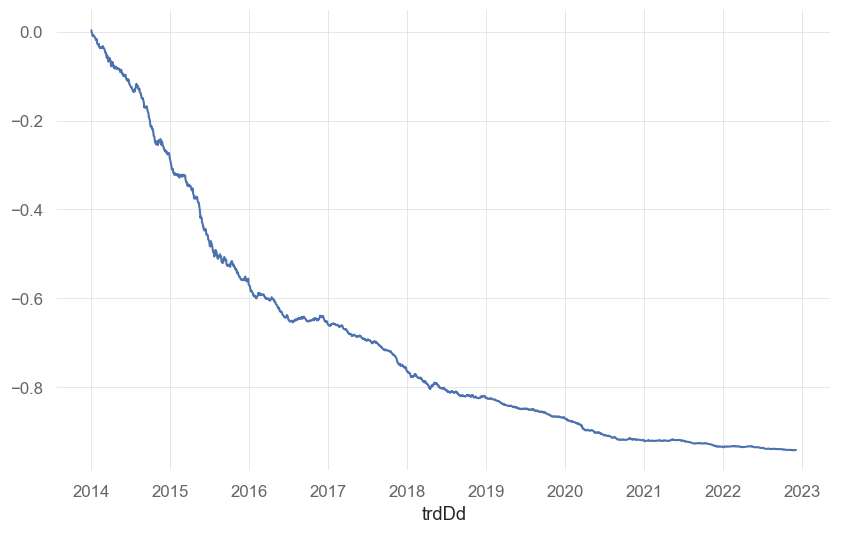

In [214]:
sns.lineplot(data=HML_factor_portfolio_PnL)

## 3. Decompose return into factor returns

각 security의 수익률을 linear regression을 통해 factor로 분해하고, 각 factor의 계수인 beta를 구한다. 

선형회귀를 할 때는 위에서 global 변수로 설정한 `WINDOW`의 기간씩 rolling하며 적용한다. 

따라서 결국 '60일 Beta' 와 같은 계수를 구하게 된다. 

In [53]:
WINDOW

252

In [54]:
return_df.shape

(2190, 3110)

beta를 dataset처럼 생성하려면 

각각의 주식(ii)에 대해 모두 factor decomposition을 위해 linear regression을 하고, 

moving window에 따라 di(기간) 에 대해서도 여러 번 해줘야 하기 때문에 일단 계산량이 많아진다. 

그리고 `WINDOW`를 무작정 키우는 것은 linear factor model이 말 그대로 linear한 관계를 가정하기에 좋지 않을 수 있다. 

그러니까 그냥 최근 `WINDOW`일 만큼만 보자

In [55]:
recent_return_df = return_df.iloc[-WINDOW:, :].copy()

backtest하려는 것이 아니므로 최근 60일 내 전체 값이 존재하지 않는 (nan이 있는) 종목들은 제외하자. 

In [56]:
recent_return_df = recent_return_df.dropna(axis=1, how='any')

In [57]:
recent_return_df.shape

(252, 2548)

In [58]:
recent_mkt_excess_R = mkt_excess_R.iloc[-WINDOW:].copy()
recent_SMB = SMB.iloc[-WINDOW:].copy()
recent_HML = HML.iloc[-WINDOW:].copy()
recent_Rf = Rf.iloc[-WINDOW:].copy()

In [59]:
recent_excess_return_df = recent_return_df.subtract(recent_Rf, axis=0)

행렬을 이용해 한 번에 beta 를 구하도록 하자. 

좌변에서 각 factor의 시계열 series는 행렬 $X$의 각 column이 된다. 

우리가 구하고자 하는 $\beta$가 들어있는 행렬 $W$는 $X$와 행렬 곱 되어야 하므로 각 column이 각 종목에 대한 regression 결과이다. 

마지막으로 우변의 행렬 $b$는 각 종목 return 시계열 series를 모아놓은 것이다. beta 행렬과 같이 각 column에 모아놓은 것이다. 

subscript의 경우 헷갈리지 않게 

- 날짜는 숫자로 (1, 2, 3, ...)
- 종목 번호는 알파벳 소문자로 (a, b, c, ...)

표기하였다. 



$$
XW = b
$$

$$
X = \begin{bmatrix}
f_{mkt, 1} & f_{SMB, 1} & f_{HML, 1} \\
f_{mkt, 2} & f_{SMB, 2} & f_{HML, 2} \\
\vdots & \vdots & \vdots & \\
f_{mkt, n} & f_{SMB, n} & f_{HML, n} \\
\end{bmatrix}
$$ 

$$
W = \begin{bmatrix}
\beta_{mkt, a} & \beta_{mkt, b} & \dots & \beta_{mkt, z} \\
\beta_{SMB, a} & \beta_{SMB, b} & \dots & \beta_{mkt, z} \\
\beta_{HML, a} & \beta_{HML, b} & \dots & \beta_{mkt, z}
\end{bmatrix}
$$

$$
b = \begin{bmatrix}
r_{a, 1} & r_{b, 1} & \dots & r_{z, 1} \\
r_{a, 2} & r_{b, 2} & \dots & r_{z, 2} \\
\vdots & \vdots & \ & \vdots & \\
r_{a, n} & r_{b, n} & \dots & r_{z, n} \\
\end{bmatrix}
$$

이 행렬에서 $W$를 구하면 우리가 원하는 종목별 factor beta들을 구할 수 있다. 

$$
W = X^{-1}b
$$

In [60]:
X = np.array([np.array(recent_mkt_excess_R), np.array(recent_SMB), np.array(recent_HML)]).T
X.shape

(252, 3)

In [61]:
b = np.array(recent_excess_return_df)
b.shape

(252, 2548)

In [62]:
solution = np.linalg.lstsq(X, b, rcond=None)

In [63]:
W, residuals, rank_of_W, singular_values_of_W = solution

In [64]:
W.shape

(3, 2548)

## 4. Plot demeaned-beta distribution after group neutralization

각 종목을 factor 분해 한 선형회귀식으로 표현한 상태에서, 

종목들을 grouping하는 어떤 기준 (KRX 산업분류라던가, size를 기준으로 10분위 나눈다던가, 종목 수익률의 correlation으로 비지도 clustering해 만든 k개 집단이라던가, 등등 ) 을 하나 골라 

같은 group에 속하는 종목들끼리 평균 수익률을 빼주는(=demean) "group neutralization" 을 한다면

k번째 집단의 평균 수익률 $r_{mean, k}$의 $f_{mkt}$ 는 $\dfrac{1}{z}\sum_{i=a}^{z} \beta_{mkt, i}$, 즉 그룹 내 종목(a, b, c, ... 로 표기)들의 market beta 평균을 계수로 가지게 되고, 

각 종목의 $\beta_{mkt, i}$ 에서 이 beta의 평균을 빼주게 되므로, 

만약 같은 그룹의 종목들이 어떤 팩터에 대해 비슷한 민감도를 가진다면 각 종목들의 beta는 그룹 내 beta의 평균을 빼고나면 거의 0에 가까워지고, 따라서 factor exposure가 거의 사라지게 된다. 

이것이 WorldQuant의 long-short portfolio 전략(=alpha)에서 다양한 group neutralization (subindustry, industry, sector 등)을 했을 때 일반적으로 Sharpe가 올라가는 결과를 낳는 이유일 것이다. 

따라서 3번에서는 Fama-French 3 factor 각각의 beta들을 모아 distribution을 plot하여 살펴보고, 

어떤 임의의 grouping으로 묶어 group neutralization을 했을 때 남은 demeaned-beta의 distribution을 plot하여 살펴봐 어떤 차이가 있는지를 확인해 볼 것이다. 

### 각 factor beta들의 distribution 살펴보기 

demeaned 되지 않은 상태의 전 종목의 beta를 factor별로 histogram을 그려본다. 

In [65]:
mkt_betas = W[0, :]
SMB_betas = W[1, :]
HML_betas = W[2, :]

#### `WINDOW=20` 일 때

In [ ]:
WINDOW

<AxesSubplot: ylabel='Count'>

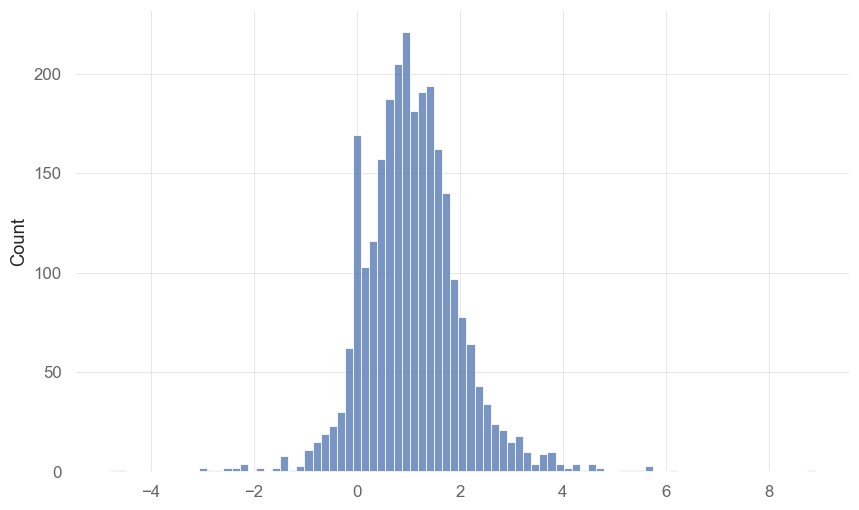

In [88]:
sns.histplot(mkt_betas)

In [89]:
scipy.stats.describe(mkt_betas)  

DescribeResult(nobs=2668, minmax=(-4.791388934897375, 8.891297423469096), mean=1.066736299428298, variance=0.9272687908203292, skewness=0.4651023048028999, kurtosis=4.633296397437826)

시장 움직임에 거의 중립적인 1 정도가 평균으로 위치하고 있다. 

<AxesSubplot: ylabel='Count'>

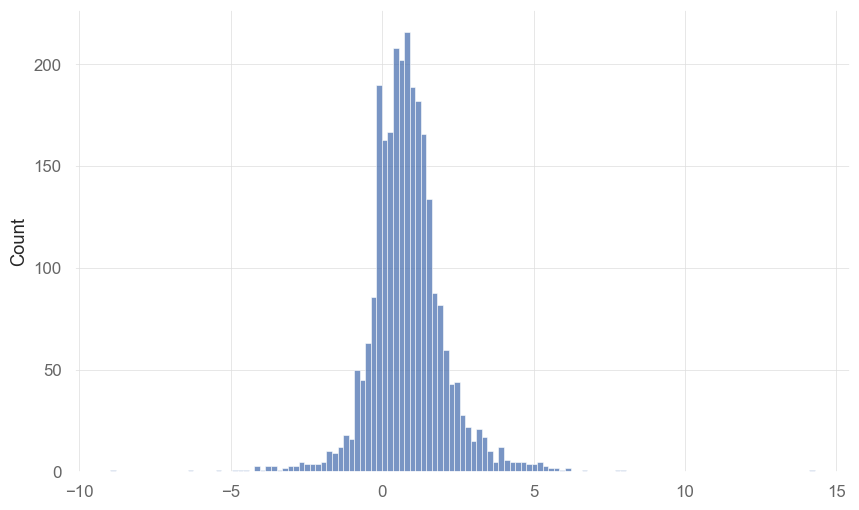

In [90]:
sns.histplot(SMB_betas)

In [91]:
scipy.stats.describe(SMB_betas)

DescribeResult(nobs=2668, minmax=(-8.984354672494597, 14.27884598926034), mean=0.8331145342320807, variance=1.6182781675236015, skewness=0.5307209452330668, kurtosis=9.212467685526963)

SMB의 경우 약간 skewed 된 결과를 보여준다. 

<AxesSubplot: ylabel='Count'>

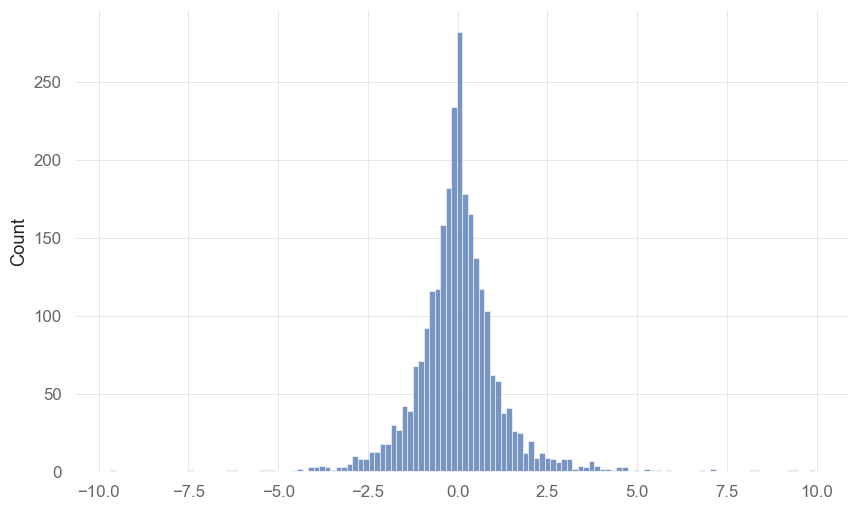

In [92]:
sns.histplot(HML_betas)

In [93]:
scipy.stats.describe(HML_betas)

DescribeResult(nobs=2668, minmax=(-9.67937842988773, 9.941000291713557), mean=0.00980569723971966, variance=1.581161095226183, skewness=0.741734152724897, kurtosis=9.754979734058418)

HML의 경우는 평균이 1이 아닌 0 근처라는 점이 특이하다. 

#### `WINDOW=60` 일 때

In [64]:
WINDOW

252

<AxesSubplot: ylabel='Count'>

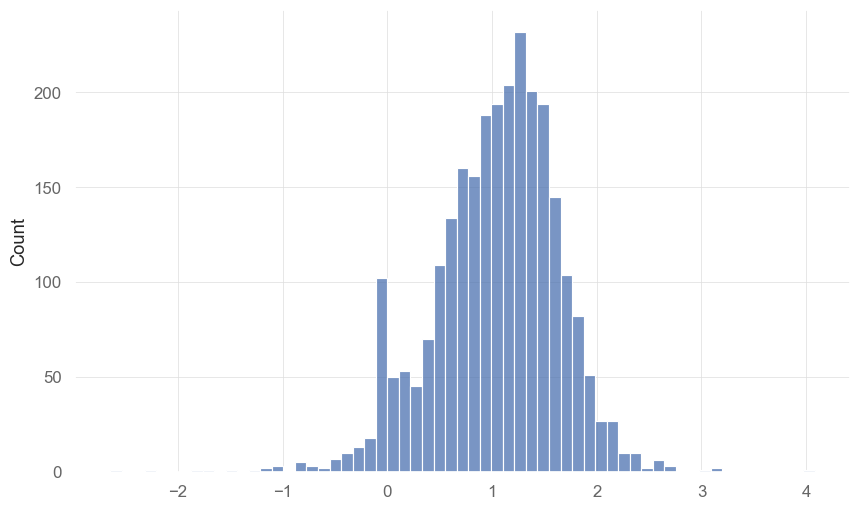

In [64]:
sns.histplot(mkt_betas)

In [73]:
scipy.stats.describe(mkt_betas)  

DescribeResult(nobs=2632, minmax=(-2.6465871582182428, 4.080377996419326), mean=1.034415691645446, variance=0.3544709719996426, skewness=-0.5017931492852096, kurtosis=1.6475751525473568)

시장 움직임에 거의 중립적인 1 정도가 평균으로 위치하고 있다. 

<AxesSubplot: ylabel='Count'>

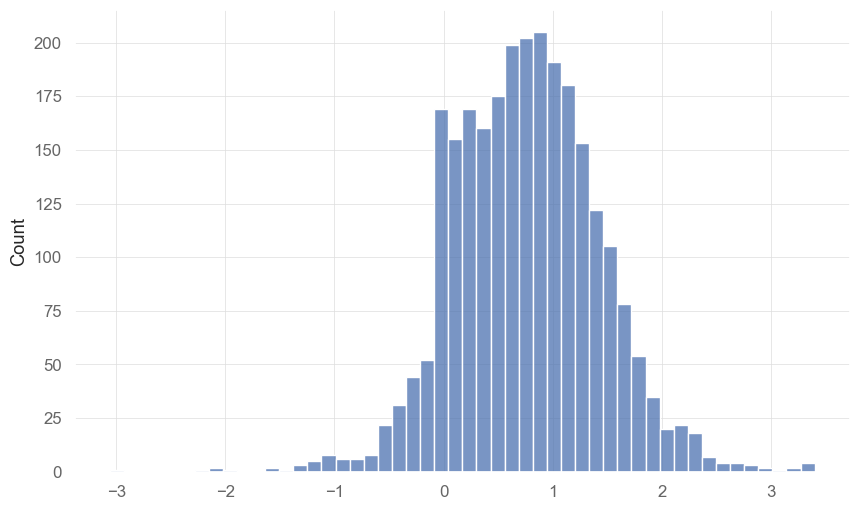

In [65]:
sns.histplot(SMB_betas)

In [74]:
scipy.stats.describe(SMB_betas)

DescribeResult(nobs=2632, minmax=(-3.055283597851307, 3.400749479698625), mean=0.754612501811373, variance=0.448269676916142, skewness=-0.0026930210953792703, kurtosis=1.1762930148304758)

SMB의 경우 약간 skewed 된 결과를 보여준다. 

<AxesSubplot: ylabel='Count'>

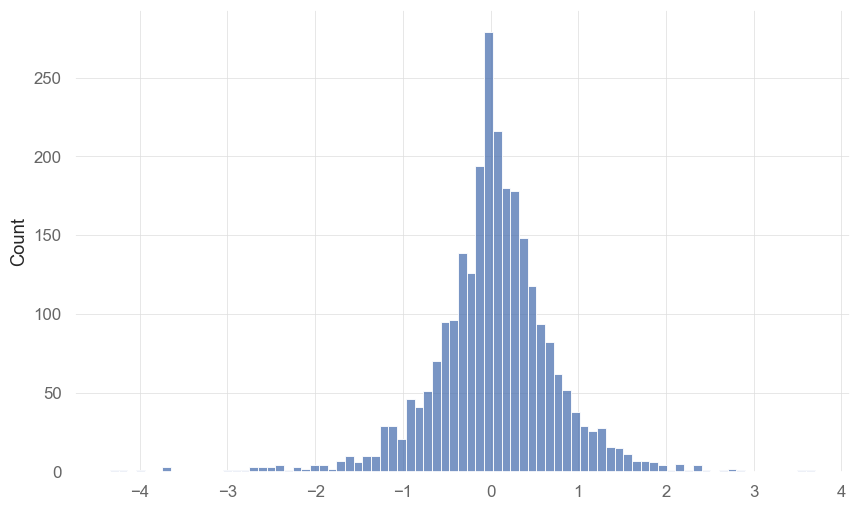

In [66]:
sns.histplot(HML_betas)

In [75]:
scipy.stats.describe(HML_betas)

DescribeResult(nobs=2632, minmax=(-4.336941988482896, 3.6944993557322237), mean=0.03518745119769351, variance=0.4891319619753283, skewness=-0.47592561781227566, kurtosis=4.262296927240529)

HML의 경우는 평균이 1이 아닌 0 근처라는 점이 특이하다. 

#### `WINDOW=252` 일 때

In [66]:
WINDOW

252

<AxesSubplot: ylabel='Count'>

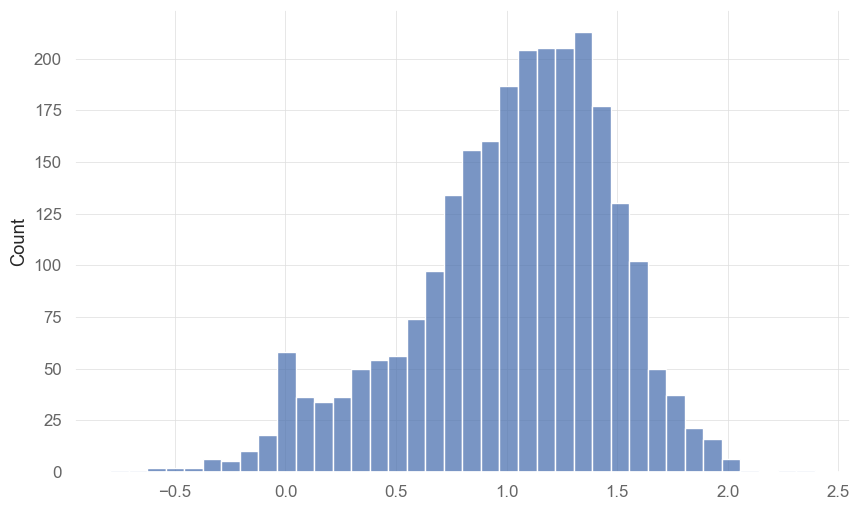

In [67]:
sns.histplot(mkt_betas)

In [68]:
scipy.stats.describe(mkt_betas)  

DescribeResult(nobs=2548, minmax=(-0.7928352311150056, 2.3926679457483604), mean=1.0258321939371877, variance=0.20522649803162601, skewness=-0.6669566066313989, kurtosis=0.3368835416959808)

시장 움직임에 거의 중립적인 1 정도가 평균으로 위치하고 있다. 

<AxesSubplot: ylabel='Count'>

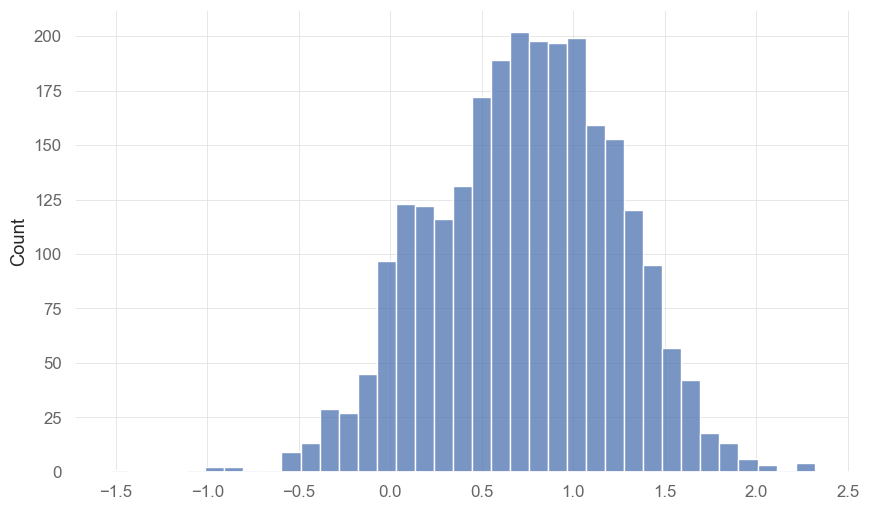

In [69]:
sns.histplot(SMB_betas)

In [70]:
scipy.stats.describe(SMB_betas)

DescribeResult(nobs=2548, minmax=(-1.5299237018335832, 2.317754420855173), mean=0.731088504416032, variance=0.25322036061840664, skewness=-0.16306543977689575, kurtosis=-0.12634613067903322)

SMB의 경우 약간 skewed 된 결과를 보여준다. 

<AxesSubplot: ylabel='Count'>

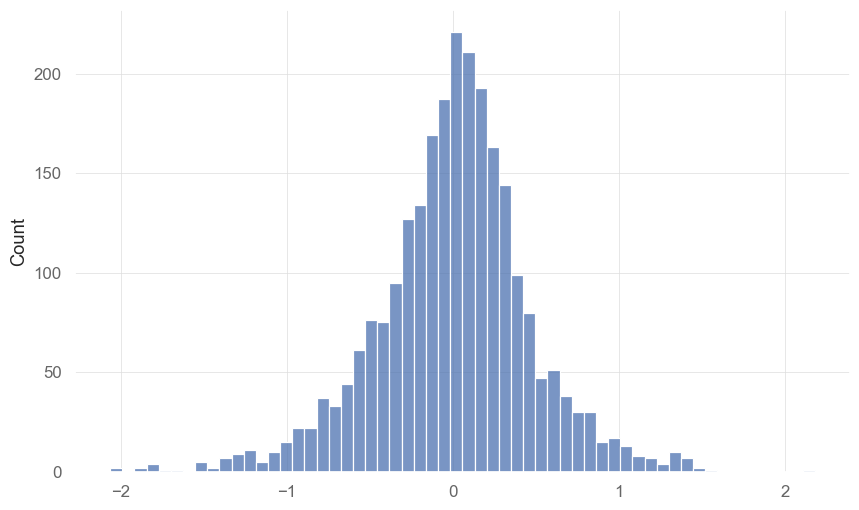

In [71]:
sns.histplot(HML_betas)

In [72]:
scipy.stats.describe(HML_betas)

DescribeResult(nobs=2548, minmax=(-2.0656569470718273, 2.178779387234694), mean=-0.0027264978394938664, variance=0.22085847195128444, skewness=-0.25124091238926893, kurtosis=1.5609971288691638)

HML의 경우는 평균이 1이 아닌 0 근처라는 점이 특이하다. 

### 몇몇 종목의 factor decomposition된 회귀식을 실제로 살펴보기



2번의 과정을 통해 이제 각 종목의 수익률은 Fama-French 3 factor에 의해 분해되어 선형회귀식으로 표현될 수 있다. 

예를 들어 삼성전자(005930)의 경우를 살펴보자

In [73]:
sam_elec_sid = '005930'

sid_list = list(return_df.columns)
sam_elec_idx = sid_list.index(sam_elec_sid)
sam_elec_idx

370

In [74]:
sam_elec_residuial = residuals[sam_elec_idx]
sam_elec_betas = W[:, sam_elec_idx]

In [75]:
result = f'''
Samsung Electronics(005930)

R = {sam_elec_residuial:04f} + {sam_elec_betas[0]:04f} * f_mkt + {sam_elec_betas[1]:04f} * f_SMB + {sam_elec_betas[2]:04f} * f_HML

'''

print(result)


Samsung Electronics(005930)

R = 0.841900 + 0.061172 * f_mkt + 1.177173 * f_SMB + -0.019146 * f_HML




이번엔 유사한 종목으로 평가받는 하이닉스(000660)의 경우를 살펴보자

In [76]:
hynx_elec_sid = '000660'
hynx_elec_idx = sid_list.index(hynx_elec_sid)

hynx_elec_residuial = residuals[hynx_elec_idx]
hynx_elec_betas = W[:, hynx_elec_idx]

result = f'''
SK Hynix(000660)

R = {hynx_elec_residuial:04f} + {hynx_elec_betas[0]:04f} * f_mkt + {hynx_elec_betas[1]:04f} * f_SMB + {hynx_elec_betas[2]:04f} * f_HML

'''
print(result)


SK Hynix(000660)

R = 0.139872 + 1.053964 * f_mkt + 0.398275 * f_SMB + 0.508658 * f_HML




음... 왜 이렇게 factor beta가 차이가 많이 나는거지? 

한 번 NAVER(035420) 와 카카오(035720) 의 경우도 살펴보자. 

In [77]:
naver_elec_sid = '035420'
naver_elec_idx = sid_list.index(naver_elec_sid)

naver_elec_residuial = residuals[naver_elec_idx]
naver_elec_betas = W[:, naver_elec_idx]

result = f'''
NAVER(035420)

R = {naver_elec_residuial:04f} + {naver_elec_betas[0]:04f} * f_mkt + {naver_elec_betas[1]:04f} * f_SMB + {naver_elec_betas[2]:04f} * f_HML

'''
print(result)


NAVER(035420)

R = 0.065739 + 1.548816 * f_mkt + 1.553757 * f_SMB + -0.050977 * f_HML




In [78]:
kakao_elec_sid = '035720'
kakao_elec_idx = sid_list.index(kakao_elec_sid)

kakao_elec_residuial = residuals[kakao_elec_idx]
kakao_elec_betas = W[:, kakao_elec_idx]

result = f'''
카카오(035720)

R = {kakao_elec_residuial:04f} + {kakao_elec_betas[0]:04f} * f_mkt + {kakao_elec_betas[1]:04f} * f_SMB + {kakao_elec_betas[2]:04f} * f_HML

'''
print(result)


카카오(035720)

R = 0.745602 + 0.951741 * f_mkt + 0.895498 * f_SMB + -0.432333 * f_HML




### 사용할 grouping data 가져오기 

#### 1. KRX Sector/Industry Grouping

가장 기본적인 grouping으로 KRX 등에서 미리 지정한 산업분류를 사용해본다. 

별도의 노트북에서 KRX industry를 가져와 lv2 dataframe으로 만들었다. 

In [79]:
with open('INDUSTRY_NAME2CODE.pickle', 'rb') as handle:
    INDUSTRY_NAME2CODE = pickle.load(handle)

In [80]:
INDUSTRY_NAME2CODE

{'서비스업': 0,
 '기타금융': 1,
 '섬유의복': 2,
 '운수창고업': 3,
 '음식료품': 4,
 '화학': 5,
 '철강금속': 6,
 '유통업': 7,
 '건설업': 8,
 '증권': 9,
 '전기전자': 10,
 '의약품': 11,
 '기계': 12,
 '종이목재': 13,
 '통신업': 14,
 '기타제조업': 15,
 '보험': 16,
 '운수장비': 17,
 '전기가스업': 18,
 '비금속광물': 19,
 '은행': 20,
 '광업': 21,
 '농업, 임업 및 어업': 22,
 '의료정밀': 23,
 '반도체': 24,
 '금속': 25,
 '기타서비스': 26,
 '방송서비스': 27,
 '유통': 28,
 '제약': 29,
 '통신장비': 30,
 'IT부품': 31,
 '기계·장비': 32,
 '오락·문화': 33,
 '운송장비·부품': 34,
 '건설': 35,
 '전기·가스·수도': 36,
 '소프트웨어': 37,
 '인터넷': 38,
 '디지털컨텐츠': 39,
 '출판·매체복제': 40,
 '금융': 41,
 '운송': 42,
 '통신서비스': 43,
 '일반전기전자': 44,
 '섬유·의류': 45,
 '컴퓨터서비스': 46,
 '음식료·담배': 47,
 '비금속': 48,
 '종이·목재': 49,
 '의료·정밀기기': 50,
 '기타제조': 51,
 '정보기기': 52,
 '숙박·음식': 53}

In [81]:
industry_df = pd.read_pickle('krx_industry_df_20140101_20221202.pickle')

In [82]:
industry_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,11.0,17.0,2.0,16.0,0.0,0.0,4.0,4.0,11.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN
2022-11-29,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN
2022-11-30,11.0,17.0,7.0,16.0,1.0,1.0,4.0,4.0,11.0,11.0,...,24.0,32.0,24.0,41.0,41.0,41.0,41.0,13.0,NaN,NaN


#### 2. Price Return Correlation Clustering Grouping

두 번째로 사용해 볼 grouping은 현재 있는 데이터셋으로 쉽게 생성할 수 있는 correlation grouping이다. 

각 주식의 return series 간 pair-wise correlation을 구하고, 이렇게 만들어진 correlation matrix의 각 row를 그 종목을 represent하는 vector로 보아 K개의 cluster로 묶는 것이다. 

이 때 clustering이 잘 되었는지는 기존 산업분류 데이터 등과 비교하여 확인할 수도 있으며, 

매 `WINDOW` 마다 clustering을 해주기 때문에 clustering의 번호가 다음 rolling 된 window에서 원래 cluster의 번호와 일치하지 않을 수 있는 문제가 존재한다. 

따라서 매번 rolling window로 clustering 해줄 때마다 이전 window에서의 어떤 cluster가 다음 window에서의 어떤 cluster에 대응할지 matching해주는 작업이 따로 필요하다. 

** correlation clustering group은 이전에 따로 만든 적이 있었으나, rolling window로 전체 dataset화 시키는 작업은 나중으로 미룸. 

### group neutralization 함수 만들기

In [83]:
def single_group_neutral(single_signal_vector):
    mean = np.nanmean(single_signal_vector)
    
    return single_signal_vector - mean

In [84]:
def multi_group_neutral(grouping_vector, signal_vector):
    group_neutralized_vector = np.zeros_like(grouping_vector)
    group_neutralized_vector[:] = np.nan

    unique_gidx = np.array(list(set(grouping_vector)))

    for gidx in unique_gidx:
        if not np.isnan(gidx):
            group_neutralized_vector[grouping_vector == gidx] = single_group_neutral(signal_vector[grouping_vector == gidx])
    
    return group_neutralized_vector

In [85]:
def group_neutralize(grouping_df, signal_df, to_numpy=False):
    assert (grouping_df.index == signal_df.index).all()
    assert (grouping_df.columns == signal_df.columns).all()

    sid_list = grouping_df.columns
    date_list = grouping_df.index

    grouping_2d = np.array(grouping_df)
    signal_2d = np.array(signal_df)

    group_neutral_2d = np.zeros_like(grouping_2d)
    group_neutral_2d[:] = np.nan

    for group_vec, signal_vec, gn_idx in zip(grouping_2d, signal_2d, range(len(group_neutral_2d))):
        group_neutral_2d[gn_idx, :] = multi_group_neutral(group_vec, signal_vec)

    if to_numpy:
        return group_neutral_2d
    else:
        return pd.DataFrame(group_neutral_2d, index=date_list, columns=sid_list)

#### group neutralization 이란? 

여러 종목들의 그룹을 나타내는 테이블과 해당 종목들의 어떤 값 (베타, 수익률, 기타 시그널 등...) 테이블이 주어졌을 때 

같은 그룹 내 종목들의 평균을 구해 각각의 종목 값에서 빼주는 것. 

예를 들어 종목들의 grouping table이 아래와 같고

|          | 10001 | 10002 | 10003 | 10004 | 10005 | 10006 | 10007  |
|----------|-------|-------|-------|-------|-------|-------|--------|
| 20220310 | 1     | 1     | 2     | 3     | 2     | 2     | 3      |
| 20220311 | 1     | 1     | 2     | 3     | 2     | 2     | 1      |
| 20220312 | 1     | 1     | 2     | 3     | 2     | 2     | np.nan |

signal table이 아래와 같다면

|          | 10001 | 10002 | 10003 | 10004 | 10005  | 10006 | 10007 |
|----------|-------|-------|-------|-------|--------|-------|-------|
| 20220310 | 100   | 50    | 200   | 100   | 150    | 0     | 250   |
| 20220311 | 150   | 100   | 150   | 50    | np.nan | 100   | 100   |
| 20220312 | 300   | 50    | 100   | 0     | 150    | 50    | 50    |

`20220310`에 `1` group에 속하는 `10001`, `10002` 두 종목의 값인 `100`과 `50`의 평균인 `75`를 각각 빼줘 `25`, `-25`를 만들어주고 나머지 그룹에 대해서도 같은 연산을 수행한다. 

이는 단순한 그룹 내 demean에 지나지 않지만, 이 연산을 통해 각 그룹 내의 값들을 평균을 중심으로 + - 로 바꿔주고, 그룹 내 종목 값들의 sum이 0이 되게 만드는 효과가 있다. 

이 연산을 factor research에서 사용하는 이유는 좀 더 아래에 적었다. 

참고: 위 테이블에 대해 구체적으로 group neutralization을 수행했을 때의 결과 

In [86]:
gdf = pd.DataFrame(
    data=[
        [1, 1, 2, 3, 2, 2, 3],
        [1, 1, 2, 3, 2, 2, 1],
        [1, 1, 2, 3, 2, 2, np.nan],
    ],
    columns=['10001', '10002', '10003', '10004', '10005', '10006', '10007'],
    index=['20220310', '20220311', '20220312'],
)

gdf

,10001,10002,10003,10004,10005,10006,10007
20220310,1,1,2,3,2,2,3.0
20220311,1,1,2,3,2,2,1.0
20220312,1,1,2,3,2,2,NaN


In [87]:
sdf = pd.DataFrame(
    data=[
        [100, 50, 200, 100, 150, 0, 250],
        [150, 100, 150, 50, np.nan, 100, 100],
        [300, 50, 100, 0, 150, 50, 50],
    ],
    columns=['10001', '10002', '10003', '10004', '10005', '10006', '10007'],
    index=['20220310', '20220311', '20220312'],
)

sdf

,10001,10002,10003,10004,10005,10006,10007
20220310,100,50,200,100,150.0,0,250
20220311,150,100,150,50,NaN,100,100
20220312,300,50,100,0,150.0,50,50


In [88]:
group_neutralize(gdf, sdf)

,10001,10002,10003,10004,10005,10006,10007
20220310,25.000000,-25.000000,83.333333,-75.0,33.333333,-116.666667,75.000000
20220311,33.333333,-16.666667,25.000000,0.0,NaN,-25.000000,-16.666667
20220312,125.000000,-125.000000,0.000000,0.0,50.000000,-50.000000,NaN


### group neutralization하여 demeaned된 beta들의 distribution을 group별로 살펴보기

위와 같이 group neutralization operation을 만든 이유는 종목들을 어떤 임의의 grouping으로 나눴을 때 각 group 내의 종목들이 공유하는 common factor에 대해 비슷한 크기의 beta exposure를 가지는지 확인하기 위함이다. 

예를 들어 테크 섹터 내의 종목이 다음과 같이 있을 때

$$
R_{삼성전자} - R_f = \alpha + \beta_{m, 삼성전자} * (R_m - R_f) + \beta_{SMB, 삼성전자} * f_{SMB} + \beta_{HML, 삼성전자} * f_{HML} + \varepsilon
\\
R_{하이닉스} - R_f = \alpha + \beta_{m, 하이닉스} * (R_m - R_f) + \beta_{SMB, 하이닉스} * f_{SMB} + \beta_{HML, 하이닉스} * f_{HML} + \varepsilon
\\
\vdots
$$

각 종목의 초과수익률의 평균은 다음과 같으며 

$$

\frac{1}{n} \sum^{n}_{i=1} (R_i - R_f) = \alpha + (\frac{1}{n} \sum^{n}_{i=1} \beta_{m, i}) \times (R_m - R_f) + (\frac{1}{n} \sum^{n}_{i=1} \beta_{SMB, i}) \times f_{SMB} + (\frac{1}{n} \sum^{n}_{i=1} \beta_{HML, i}) \times f_{HML} + 0

$$

group neutralization을 하듯 개별 종목의 factor decomposition에서 이 평균을 빼주게 되면 다음과 같고

$$

(R_{삼성전자} - R_f) - \frac{1}{n} \sum^{n}_{i=1} (R_i - R_f) = 0 + (\beta_{m, 삼성전자} - \frac{1}{n} \sum^{n}_{i=1} \beta_{m, i}) * (R_m - R_f) + (\beta_{SMB, 삼성전자} - \frac{1}{n} \sum^{n}_{i=1} \beta_{SMB, i}) * f_{SMB} + (\beta_{HML, 삼성전자} - \frac{1}{n} \sum^{n}_{i=1} \beta_{HML, i}) * f_{HML} + \varepsilon

$$

이 때, 만약 어떤 grouping `grouping_A`로 묶여진 종목들이 각 common factor에 대해 비슷한 beta exposure를 가진다면 

개별 종목의 각 factor 별 beta에서 같은 그룹 내 beta의 평균을 빼준 값들. 즉, demeaned 된 beta들의 distribution은 0을 중심으로 좁게 퍼져있을 것이다. 

반대로 만약 다른 grouping `grouping_B`로 묶여진 종목들이 각 common factor에 대해 비슷한 beta exposure를 가지지 않는다면 

demeaned beta distribution은 0을 중심으로 넓게 퍼져있을 것이고, 이는 `grouping_A`가 `grouping_B`보다 유사한 factor exposure를 가지는 종목끼리 잘 묶어주는 grouping이라는 것을 의미할 것이다. 

이와 같은 생각을 바탕으로, 이미 구해놓은 market betas / SMB betas / HML betas 들에 대해 group neutralization을 수행하고 demeaned beta의 distribution을 살펴보겠다. 

In [89]:
grouping_vector = industry_df.iloc[-1, :]
grouping_vector = np.array(grouping_vector[recent_return_df.columns].tolist()) # 위에서도 WINDOW 기간 중 nan이 들어있는 것을 모두 drop 해줬으므로, 종목 리스트를 beta를 구할 때와 같게 맞춘다. 

In [90]:
demeaned_mkt_betas = multi_group_neutral(grouping_vector, mkt_betas)

<AxesSubplot: ylabel='Count'>

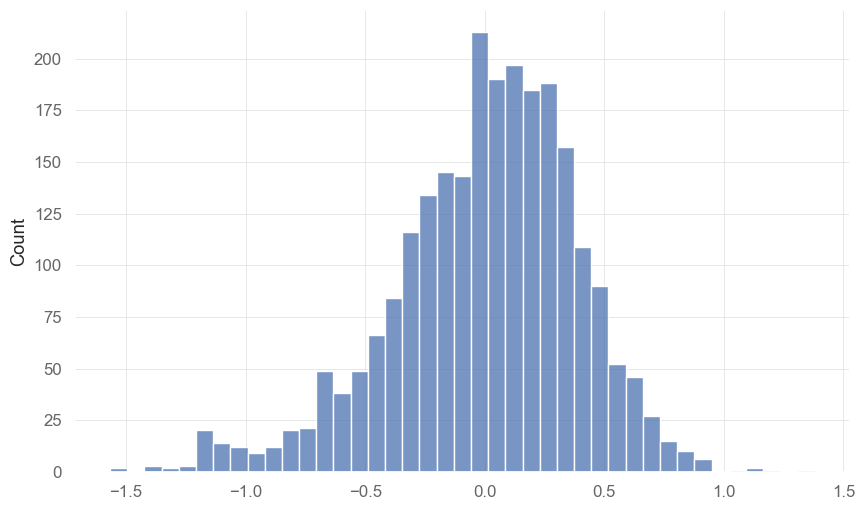

In [91]:
sns.histplot(demeaned_mkt_betas)

In [92]:
scipy.stats.describe(demeaned_mkt_betas, nan_policy='omit')

DescribeResult(nobs=2432, minmax=(masked_array(data=-1.56621105,
             mask=False,
       fill_value=1e+20), masked_array(data=1.37967033,
             mask=False,
       fill_value=1e+20)), mean=-4.8937462269661503e-17, variance=0.15221779047848283, skewness=masked_array(data=-0.60747784,
             mask=False,
       fill_value=1e+20), kurtosis=0.7922216924906933)

In [93]:
demeaned_SMB_betas = multi_group_neutral(grouping_vector, SMB_betas)

<AxesSubplot: ylabel='Count'>

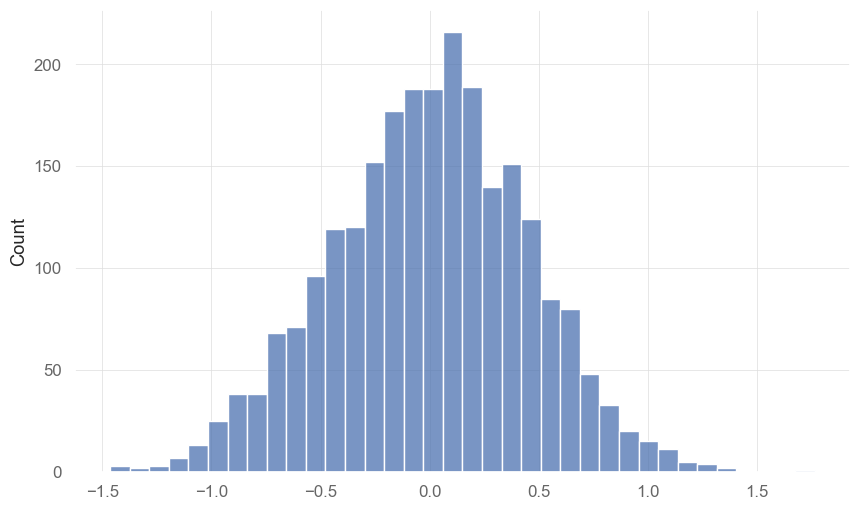

In [94]:
sns.histplot(demeaned_SMB_betas)

In [95]:
scipy.stats.describe(demeaned_SMB_betas, nan_policy='omit')

DescribeResult(nobs=2432, minmax=(masked_array(data=-1.46426185,
             mask=False,
       fill_value=1e+20), masked_array(data=1.76313309,
             mask=False,
       fill_value=1e+20)), mean=3.652049423109067e-18, variance=0.2028170239613983, skewness=masked_array(data=-0.07568946,
             mask=False,
       fill_value=1e+20), kurtosis=-0.058328834099758975)

In [96]:
demeaned_HML_betas = multi_group_neutral(grouping_vector, HML_betas)

<AxesSubplot: ylabel='Count'>

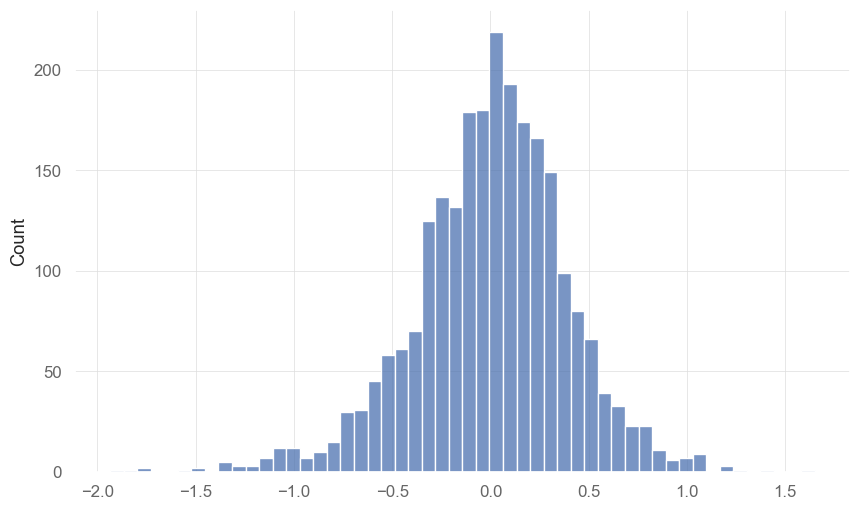

In [97]:
sns.histplot(demeaned_HML_betas)

In [98]:
scipy.stats.describe(demeaned_HML_betas, nan_policy='omit')

DescribeResult(nobs=2432, minmax=(masked_array(data=-1.93538399,
             mask=False,
       fill_value=1e+20), masked_array(data=1.64972732,
             mask=False,
       fill_value=1e+20)), mean=2.921639538487254e-18, variance=0.15562875461896317, skewness=masked_array(data=-0.41252802,
             mask=False,
       fill_value=1e+20), kurtosis=1.4602922967701115)

### Beta들의 std normal distribution을 비교

In [99]:
std_normal_mkt_betas = scipy.stats.zscore(mkt_betas)
std_normal_HML_betas = scipy.stats.zscore(HML_betas)
std_normal_SMB_betas = scipy.stats.zscore(SMB_betas)

In [100]:
std_normal_betas = pd.DataFrame(
    data=list(zip(
        std_normal_mkt_betas,
        std_normal_SMB_betas,
        std_normal_HML_betas
    )),
    columns=[
        'std_normal_mkt_beta',
        'std_normal_SMB_beta',
        'std_normal_HML_beta',
    ]
    )

<AxesSubplot: ylabel='Count'>

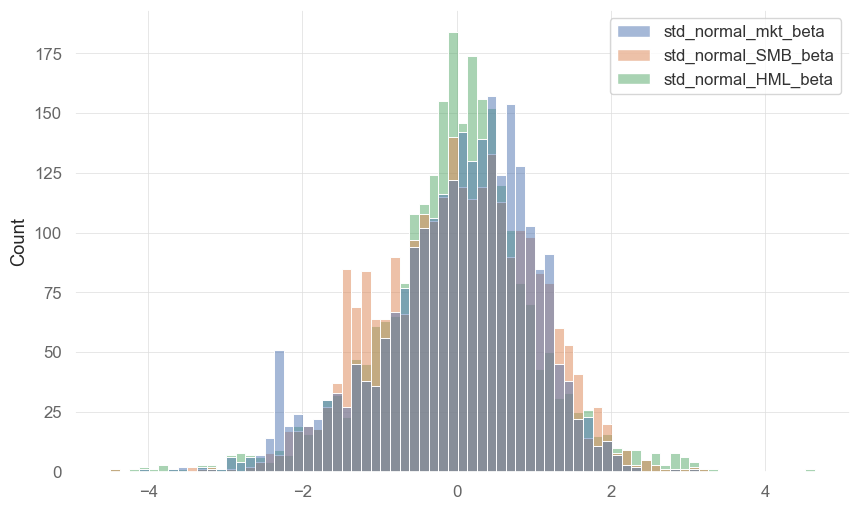

In [101]:
sns.histplot(data=std_normal_betas)

## 5. Group 간 beta의 비교

### Group selector 만들기

In [102]:
grouping_vector

array([11., 17.,  7., ...,  1., 26.,  0.])

In [103]:
def select_group(group_code):
    selected_series = (grouping_vector == group_code)

    return selected_series

### 대표 group 끼리 beta distribution 비교

화학이 LG화학을 대장주로 큰 주식 위주로 모여있다. 

제약은 작은 주식 위주로 크기가 비슷비슷하다. 

화학은 대표적인 value주고 

제약은 대표적인 growth주다. 

In [104]:
INDUSTRY_NAME2CODE.keys()

dict_keys(['서비스업', '기타금융', '섬유의복', '운수창고업', '음식료품', '화학', '철강금속', '유통업', '건설업', '증권', '전기전자', '의약품', '기계', '종이목재', '통신업', '기타제조업', '보험', '운수장비', '전기가스업', '비금속광물', '은행', '광업', '농업, 임업 및 어업', '의료정밀', '반도체', '금속', '기타서비스', '방송서비스', '유통', '제약', '통신장비', 'IT부품', '기계·장비', '오락·문화', '운송장비·부품', '건설', '전기·가스·수도', '소프트웨어', '인터넷', '디지털컨텐츠', '출판·매체복제', '금융', '운송', '통신서비스', '일반전기전자', '섬유·의류', '컴퓨터서비스', '음식료·담배', '비금속', '종이·목재', '의료·정밀기기', '기타제조', '정보기기', '숙박·음식'])

In [105]:
chemi_bool_list = select_group(INDUSTRY_NAME2CODE['화학'])

In [106]:
pharma_bool_list = select_group(INDUSTRY_NAME2CODE['제약'])

### sector별 beta distribution 비교

#### market beta

In [107]:
compare_mkt_betas = pd.DataFrame(
    data=list(zip(
        mkt_betas[chemi_bool_list],
        mkt_betas[pharma_bool_list],
    )),
    columns=[
        'chemi_mkt_beta',
        'pharma_mkt_beta',
    ]
)

<AxesSubplot: ylabel='Count'>

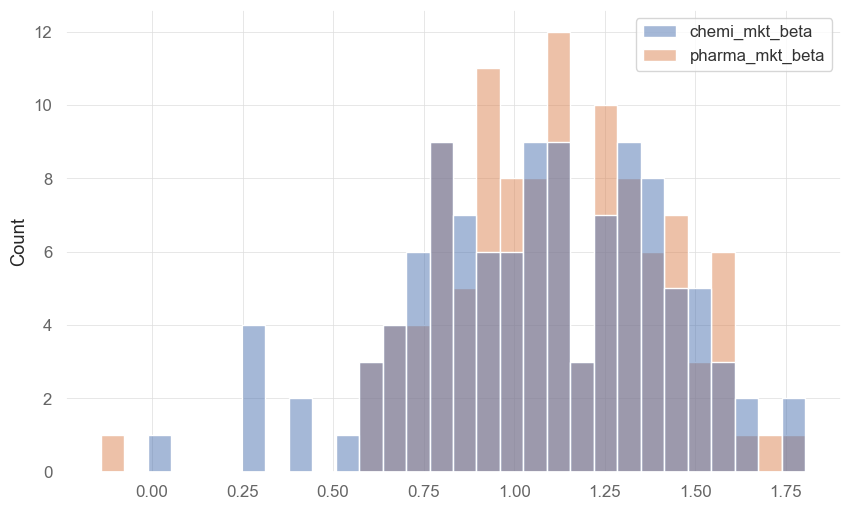

In [108]:
sns.histplot(compare_mkt_betas, bins=30)

#### SMB beta

In [109]:
compare_SMB_betas = pd.DataFrame(
    data=list(zip(
        SMB_betas[chemi_bool_list],
        SMB_betas[pharma_bool_list],
    )),
    columns=[
        'chemi_SMB_beta',
        'pharma_SMB_beta',
    ]
)

<AxesSubplot: ylabel='Count'>

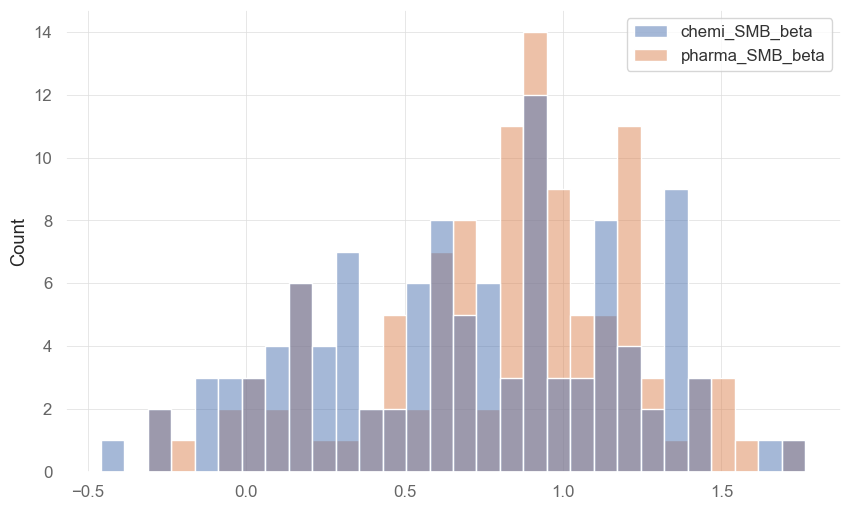

In [110]:
sns.histplot(compare_SMB_betas, bins=30)

#### HML beta

가장 확연하게 팩터 익스포져 차이를 보여준다. 

예상대로 growth 중심의 pharma와 value 중심의 chemi가 갈리는 모습을 보여준다. 

In [111]:
compare_HML_betas = pd.DataFrame(
    data=list(zip(
        HML_betas[chemi_bool_list],
        HML_betas[pharma_bool_list],
    )),
    columns=[
        'chemi_HML_beta',
        'pharma_HML_beta',
    ]
)

<AxesSubplot: ylabel='Count'>

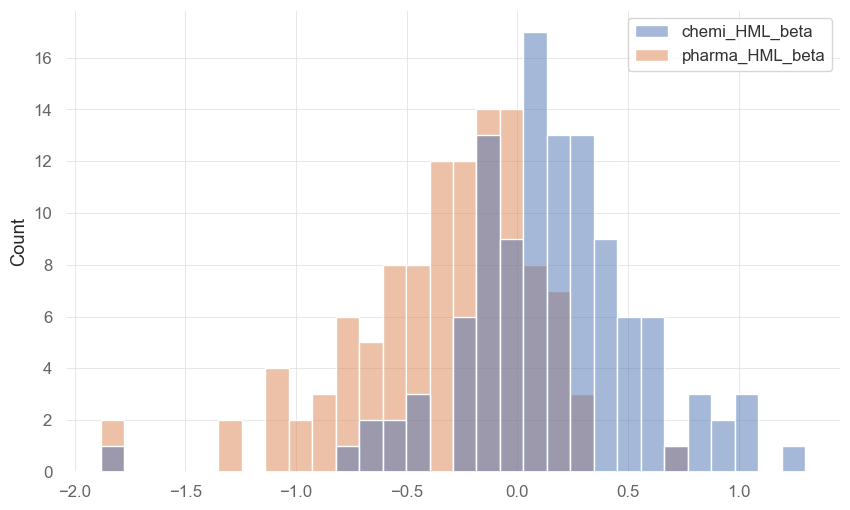

In [112]:
sns.histplot(compare_HML_betas, bins=30)

### factor별 beta의 treemap

In [ ]:
tree_sid_list = recent_return_df.columns

In [133]:
recent_marcap_row = marcap_df.iloc[-1, :]
recent_marcap_row = np.array(recent_marcap_row[tree_sid_list].tolist())

In [120]:
INDUSTRY_CODE2NAME = {v:k for k,v in INDUSTRY_NAME2CODE.items()}

일단 이전에 만들어둔 sid to name mapper를 써 종목코드를 이름으로 매핑한다. 

In [ ]:
with open('sid2name.pkl', 'rb') as p:
    sid2name = pickle.load(p)

In [134]:
treemap_data_df = pd.DataFrame(
    list(zip(
        grouping_vector,
        tree_sid_list,
        recent_marcap_row,
        mkt_betas,
        SMB_betas,
        HML_betas,
    )),
    columns=[
        'industry_code',
        'sid',
        'marcap',
        'market_beta',
        'SMB_beta',
        'HML_beta',
    ]
)

In [135]:
treemap_data_df['industry_name'] = treemap_data_df['industry_code'].apply(lambda gid: INDUSTRY_CODE2NAME[gid] if gid in INDUSTRY_CODE2NAME else '기타')

In [136]:
treemap_data_df['company_name'] = treemap_data_df['sid'].apply(lambda sid: sid2name[sid] if sid in sid2name else '종목이름없음')

In [141]:
beta_name = 'market_beta'

treemap_fig = px.treemap(
    treemap_data_df, 
    path=[
        px.Constant('KOSPI & KOSDAQ'),
        'industry_name',
        'company_name',
    ],
    values='marcap',
    color=beta_name,
    # hover_data=[],
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data_df[beta_name])
)

treemap_fig.update_layout(margin=dict(t=50, l=25, b=25))
treemap_fig.show()


In [142]:
beta_name = 'SMB_beta'

treemap_fig = px.treemap(
    treemap_data_df, 
    path=[
        px.Constant('KOSPI & KOSDAQ'),
        'industry_name',
        'company_name',
    ],
    values='marcap',
    color=beta_name,
    # hover_data=[],
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data_df[beta_name])
)

treemap_fig.update_layout(margin=dict(t=50, l=25, b=25))
treemap_fig.show()


In [143]:
beta_name = 'HML_beta'

treemap_fig = px.treemap(
    treemap_data_df, 
    path=[
        px.Constant('KOSPI & KOSDAQ'),
        'industry_name',
        'company_name',
    ],
    values='marcap',
    color=beta_name,
    # hover_data=[],
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data_df[beta_name])
)

treemap_fig.update_layout(margin=dict(t=50, l=25, b=25))
treemap_fig.show()
